In [5]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import ResNet152V2

In [6]:
import tensorflow as tf;
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-08 15:11:06.809220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:11:06.826967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:11:06.826992: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [12]:
# Cell 2: Define constants
BATCH_SIZE = 32
IMG_HEIGHT = 224 #ResNet152V2
IMG_WIDTH = 224
DATA_DIR = "/home/anon/MajorProject/Data/Dataset_alpha"

In [13]:
# Cell 3: Load data
#If the data is not separated into test and train directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)
#if the test and train data is separated
# TRAIN_DATA_DIR = "..\Data\Synthetic_Dataset\Train"
# TEST_DATA_DIR = "..\Data\Synthetic_Dataset\Test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 1500 files belonging to 16 classes.
Using 1200 files for training.


2024-02-08 15:13:41.155368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:13:41.155413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:13:41.155425: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:13:41.282175: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-08 15:13:41.282219: I external/local_xla/xla/stream_executor

Found 1500 files belonging to 16 classes.
Using 300 files for validation.
['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Initiation', 'Left_Click', 'Neutral', 'Nothing', 'Play', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'Volume_Decrease', 'Volume_Increase']


In [31]:
# Cell 4: Define data augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.3),
        layers.RandomBrightness(0.4),
        # layers.RandomWidth(0.2),
        layers.Resizing(IMG_WIDTH, IMG_HEIGHT)  # Add this line
    ]
)


In [32]:
# Cell 5:
#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [33]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = ResNet152V2(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.3
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="ResNet152V2")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])


In [17]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your model
plot_model(model, to_file='ResNet152V2_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
print(model.summary())

Model: "ResNet152V2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [34]:
# Cell 7: Define callbacks
# from tf.keras.callbacks import ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Checkpoints/Dataset_alpha/checkpoint-{epoch:02d}-{val_accuracy:.4f}.keras'
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              # patience=5, min_lr=0.001)
# model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)
# model_checkpoint = ModelCheckpoint(monitor='val_accuracy', mode='max', save_best_only=True)


In [35]:
#Cell 8 train the model
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/30


2024-02-08 15:24:40.230861: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at list_kernels.h:206 : INVALID_ARGUMENT: PartialTensorShape: Incompatible shapes during merge: [224,252,3] vs. [224,193,3]
2024-02-08 15:24:40.231035: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17207538499212303391
2024-02-08 15:24:40.231104: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 242977353031069938
2024-02-08 15:24:40.292559: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at list_kernels.h:206 : INVALID_ARGUMENT: PartialTensorShape: Incompatible shapes during merge: [224,246,3] vs. [224,257,3]


InvalidArgumentError: Graph execution error:

Detected at node map/TensorArrayV2Stack/TensorListStack defined at (most recent call last):
<stack traces unavailable>
Detected at node map/TensorArrayV2Stack/TensorListStack defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:   PartialTensorShape: Incompatible shapes during merge: [224,252,3] vs. [224,193,3]
	 [[{{node map/TensorArrayV2Stack/TensorListStack}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_4]]
  (1) INVALID_ARGUMENT:   PartialTensorShape: Incompatible shapes during merge: [224,252,3] vs. [224,193,3]
	 [[{{node map/TensorArrayV2Stack/TensorListStack}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_105379]

In [8]:
# Cell 10: Save the model
# model.save('/content/drive/MyDrive/Colab Notebooks/ResNet152V2.h5')
model.save('..\Models\ResNet152.keras')

In [29]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (32, 224, 224, 3), labels shape: (32,)
Validation images shape: (32, 224, 224, 3), labels shape: (32,)


In [9]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 1s 1s/step


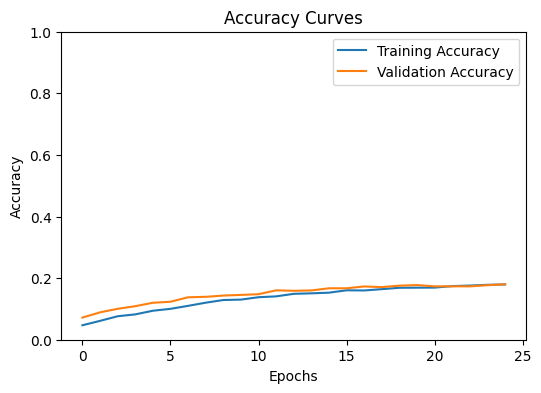

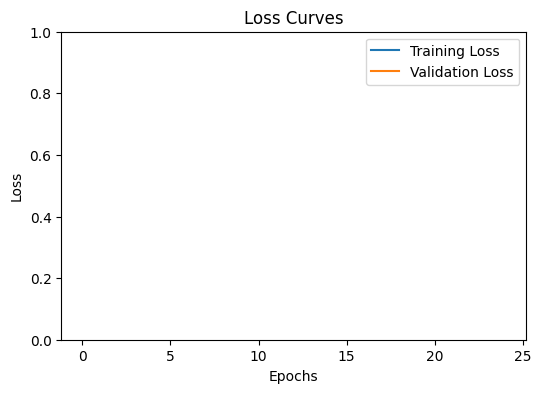

ModuleNotFoundError: No module named 'sklearn'

In [10]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on the problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

# Assuming class_names is a list of your class names in the order they were encoded
# class_names = ["Brightness_Decrease", "Brightness_Increase", "Chrome_Open", "Cursor_Movement", "Double_Click", "Initiation", "Left_Click", "Neutral", "Nothing", "Right_Click", "Screenshot", "Scroll", "Shutdown", "Volume_Decrease", "Volume_Increase"]
class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 pool1_pad
4 pool1_pool
5 conv2_block1_preact_bn
6 conv2_block1_preact_relu
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_pad
11 conv2_block1_2_conv
12 conv2_block1_2_bn
13 conv2_block1_2_relu
14 conv2_block1_0_conv
15 conv2_block1_3_conv
16 conv2_block1_out
17 conv2_block2_preact_bn
18 conv2_block2_preact_relu
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_pad
23 conv2_block2_2_conv
24 conv2_block2_2_bn
25 conv2_block2_2_relu
26 conv2_block2_3_conv
27 conv2_block2_out
28 conv2_block3_preact_bn
29 conv2_block3_preact_relu
30 conv2_block3_1_conv
31 conv2_block3_1_bn
32 conv2_block3_1_relu
33 conv2_block3_2_pad
34 conv2_block3_2_conv
35 conv2_block3_2_bn
36 conv2_block3_2_relu
37 max_pooling2d
38 conv2_block3_3_conv
39 conv2_block3_out
40 conv3_block1_preact_bn
41 conv3_block1_preact_relu
42 conv3_block1_1_conv
43 conv3_block1_1_bn
44 conv3_block1_1_relu
45 conv3_block1_2_pad
46 

In [13]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# we chose to train the top 2 blocks, i.e. we will freeze
# the first 566 layers and unfreeze the rest:
for layer in model.layers[:566]:
   layer.trainable = False
for layer in model.layers[566:]:
   layer.trainable = True
# we need to recompile the model for these modifications to take effect
# we train our model again (this time fine-tuning the top 2 blocks
# alongside the top Dense layers
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 15
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/15
38/38 [==============================] - 41s 796ms/step - loss: 2.0716 - accuracy: 0.4367 - sparse_categorical_accuracy: 0.4367 - sparse_top_k_categorical_accuracy: 0.8025 - val_loss: 1.3569 - val_accuracy: 0.7033 - val_sparse_categorical_accuracy: 0.7033 - val_sparse_top_k_categorical_accuracy: 0.9600
Epoch 2/15
38/38 [==============================] - 27s 690ms/step - loss: 2.0385 - accuracy: 0.4275 - sparse_categorical_accuracy: 0.4275 - sparse_top_k_categorical_accuracy: 0.8308 - val_loss: 1.3567 - val_accuracy: 0.7033 - val_sparse_categorical_accuracy: 0.7033 - val_sparse_top_k_categorical_accuracy: 0.9600
Epoch 3/15
38/38 [==============================] - 27s 690ms/step - loss: 2.0667 - accuracy: 0.4258 - sparse_categorical_accuracy: 0.4258 - sparse_top_k_categorical_accuracy: 0.8100 - val_loss: 1.3564 - val_accuracy: 0.7033 - val_sparse_categorical_accuracy: 0.7033 - val_sparse_top_k_categorical_accuracy: 0.9600
Epoch 4/15
38/38 [==============================] - 27s

In [14]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 3s 3s/step


Accuracy: 0.7066666666666667
Precision: 0.7494733340947501
Recall: 0.7353498217468805
F1 Score: 0.7095514605975379
AUC-ROC: 0.8571964034758935


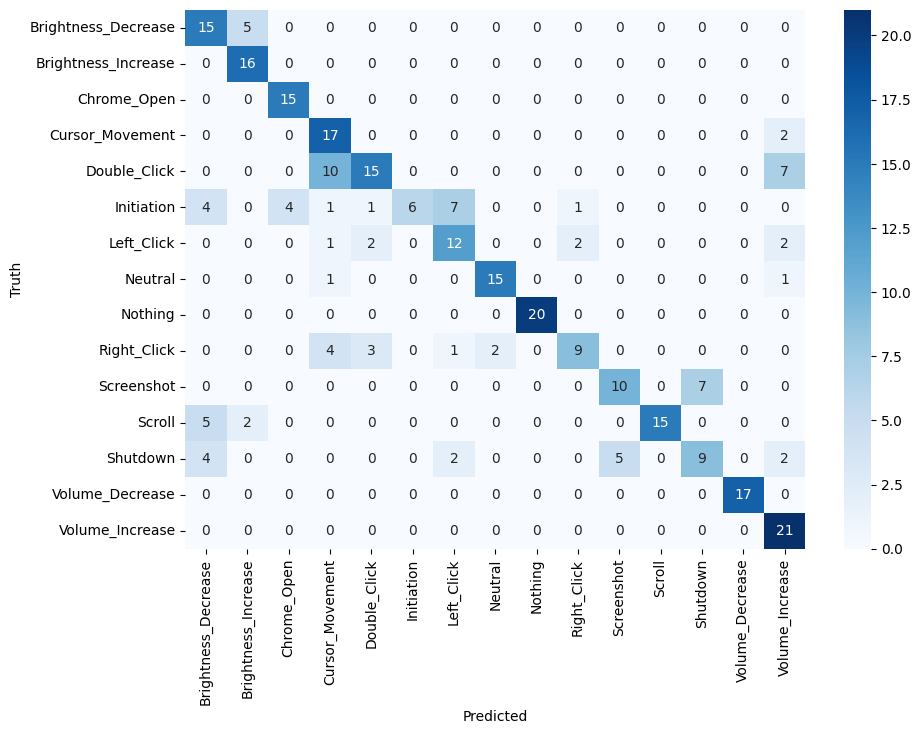

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on the problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

# Assuming class_names is a list of your class names in the order they were encoded
class_names = ["Brightness_Decrease", "Brightness_Increase", "Chrome_Open", "Cursor_Movement", "Double_Click", "Initiation", "Left_Click", "Neutral", "Nothing", "Right_Click", "Screenshot", "Scroll", "Shutdown", "Volume_Decrease", "Volume_Increase"]

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9849130670042701


In [16]:
# model.save('/content/drive/MyDrive/Colab Notebooks/EfficientNetB6_without_onehot_finetuned.h5')
model.save('/content/drive/MyDrive/Colab Notebooks/ResNet152V2_finetuned.keras')

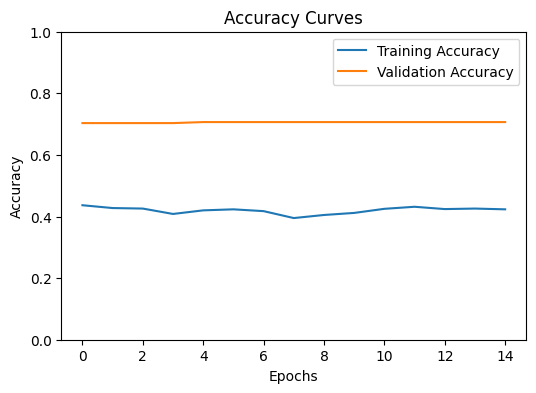

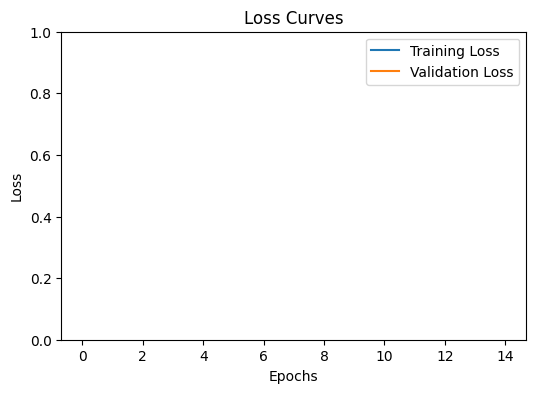

In [17]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
